In [3]:
# ===========================================================================================================
# IMPORT ZONE
# ===========================================================================================================

import numpy as np
import harmonic_functions as hfu

from scipy.linalg import sqrtm

# ===========================================================================================================
# PARAM CLASS
# ===========================================================================================================

class Param:
  """
  Param: 
    Container for holding all simulation parameters.
  """
  def __init__(self,
               x_min: float,
               x_max: float,
               num_x: int,
               tsim: float,
               num_t: int,
               tc: float,
               num_tc:int,
               im_time: bool = False) -> None:
    """
    __init__ : 
      Initialize simulation parameters.

    Parameters
    ----------
    x_min : float
      Minimum spatial value.
    x_max : float
      Maximum spatial value.
    num_x : int
      Number of spatial grid points.
    tsim : float
      Total simulation time.
    num_t : int
      Number of time steps.
    im_time : bool, optional
      Whether to use imaginary time evolution. Default is False.
    """
    # Initialization
    self.x_min = x_min
    self.x_max = x_max
    self.num_x = num_x
    self.tsim = tsim
    self.num_t = num_t
    self.tc = tc
    self.num_tc = num_tc
    self.im_time = im_time

    # Infinitesimal quantities (space, time, momentum)
    self.dx = (x_max - x_min) / num_x
    self.dt = tsim / num_t
    self.dk = 2 * np.pi / (x_max - x_min)
    
    # Store total evolution time
    self.total_time = 0
    
    # Check consistency in time-grids
    assert (np.allclose(self.dt, tc / num_tc))

    # Spatial grid
    self.x = np.linspace(x_min + 0.5 * self.dx, x_max - 0.5 * self.dx, num_x)

    # Momentum grid -> For FFT, frequencies are in this order
    self.k = np.fft.fftfreq(num_x, d=self.dx) * 2 * np.pi

    # validation check
    self._validate()

  def _validate(self) -> None:
    """
    _validate :
      Check for common errors in parameter initialization.
    """
    if self.num_x <= 0 or self.num_t <= 0:
      raise ValueError("num_x and num_t must be both positive integers. \nGot num_x={num_x} and num_t={num_t}.", stop=True)
    if self.x_max <= 0 or self.tsim <= 0:
      raise ValueError("xmax and tsim must be both positive integers. \nGot xmax={xmax} and tsim={tsim}.", stop=True)


In [4]:
# ===========================================================================================================
# IMPORT ZONE
# ===========================================================================================================

import numpy as np

from scipy.linalg import eigh
from scipy.special import factorial
from scipy.sparse import diags


# ===========================================================================================================
# FINITE DIFFERENCE METHOD
# ===========================================================================================================

def kinetic_matrix(x, order=2):
  """
  kinetic_matrix:
    Computes the kinetic energy matrix for the finite difference method using sparse matrices.

  Parameters
  ----------
  x : np.ndarray
    Real space grid.
  order : int, optional
    Order of the finite difference approximation (2, 4, 6, 8). Default is 2.

  Returns
  -------
  K : scipy.sparse.csr_matrix
    The kinetic energy matrix in sparse format.
  """
  # Grid params
  dx = x[1] - x[0]
  factor = 2 / (dx**2)
  N = len(x)
  
  # Define diagonals and offsets for different finite difference orders
  if order == 2:
    diagonals = [
      factor * np.ones(N),                 # Main diagonal
      -factor / 2 * np.ones(N - 1),        # First upper diagonal
      -factor / 2 * np.ones(N - 1),        # First lower diagonal
    ]
    offsets = [0, 1, -1]
  
  elif order == 4:
    diagonals = [
      5 * factor / 4 * np.ones(N),         # Main diagonal
      -2 * factor / 3 * np.ones(N - 1),    # First upper diagonal
      -2 * factor / 3 * np.ones(N - 1),    # First lower diagonal
      factor / 24 * np.ones(N - 2),        # Second upper diagonal
      factor / 24 * np.ones(N - 2),        # Second lower diagonal
    ]
    offsets = [0, 1, -1, 2, -2]
  
  elif order == 6:
    diagonals = [
      49 * factor / 36 * np.ones(N),       # Main diagonal
      -3 * factor / 4 * np.ones(N - 1),    # First upper diagonal
      -3 * factor / 4 * np.ones(N - 1),    # First lower diagonal
      3 * factor / 40 * np.ones(N - 2),    # Second upper diagonal
      3 * factor / 40 * np.ones(N - 2),    # Second lower diagonal
      -factor / 180 * np.ones(N - 3),      # Third upper diagonal
      -factor / 180 * np.ones(N - 3),      # Third lower diagonal
    ]
    offsets = [0, 1, -1, 2, -2, 3, -3]
  
  elif order == 8:
    diagonals = [
      205 * factor / 144 * np.ones(N),     # Main diagonal
      -4 * factor / 5 * np.ones(N - 1),    # First upper diagonal
      -4 * factor / 5 * np.ones(N - 1),    # First lower diagonal
      factor / 10 * np.ones(N - 2),        # Second upper diagonal
      factor / 10 * np.ones(N - 2),        # Second lower diagonal
      -4 * factor / 315 * np.ones(N - 3),  # Third upper diagonal
      -4 * factor / 315 * np.ones(N - 3),  # Third lower diagonal
      factor / 1120 * np.ones(N - 4),      # Fourth upper diagonal
      factor / 1120 * np.ones(N - 4),      # Fourth lower diagonal
    ]
    offsets = [0, 1, -1, 2, -2, 3, -3, 4, -4]
  
  else:
    raise ValueError(f"Unsupported order (order = {order}). \nPlease choose order = 2, 4, 6, or 8.")
  
  # Create the sparse matrix using scipy.sparse.diags
  K = diags(diagonals, offsets, format="csr")
  
  return K


# ===========================================================================================================

def COM_hamiltonian(x, omega, order=2):
  """
  hamiltonian: 
    Constructs the Hamiltonian matrix for the harmonic oscillator
    (using the finite difference numerical method).

  Parameters
  ----------
  x : np.ndarray
    Real space grid.
  omega : float
    Angular frequency of the harmonic oscillator.
  order : int, optional
    Order of finite difference approximation. Default is 2.

  Returns
  -------
  H : np.ndarray
    The Hamiltonian matrix.
  """  
  # Construct the Hamiltonian matrix
  K = kinetic_matrix(x, order)
  
  V_diag = omega**2  * x**2
  V = np.diag(V_diag)

  H = K + V
  return H

# ===========================================================================================================

def COM_spectrum(x, omega, order=2, n_max=1):
  """
  harmonic_oscillator_spectrum:
    Computes the eigenvalues and eigenfunctions of the harmonic oscillator
    (using the finite difference numerical method).

  Parameters
  ----------
  x : np.ndarray
    Real space grid.
  omega : float
    Angular frequency of the harmonic oscillator.
  order : int, optional
    Order of finite difference approximation. Default is 2.
  n_max : int, optional
    Number of wavefunctions to return. Default is 1 (ground state).

  Returns
  -------
  np.ndarray
    Normalized wavefunctions.
  """
  # Eigenvalues and eigenfunctions computation
  H = COM_hamiltonian(x, omega, order)
  _, psi = eigh(H)
  
  # Eigenfunctions flipping (for consistence with analytical solutions)
  center_index = len(x) // 2

  for i in range(len(psi)):
    if i % 2 == 0:
      # Ensure the wavefunction is positive at the center
      if ((i//2)%2==0 and psi[:, i][center_index] < 0) or ((i//2)%2!=0 and psi[:, i][center_index] > 0):
        psi[:, i] *= -1
    else :
      # Find the first peak after the center
      for j in range(center_index, len(psi[:, i]) - 1):
        if abs(psi[:, i][j]) > abs(psi[:, i][j + 1]):  # First peak condition
          first_peak_index = j
          break
      # Adjust sign based on desired pattern
      if (i % 4 == 1 and psi[:, i][first_peak_index] < 0):  # Positive peaks
        psi[:, i] *= -1
      elif (i % 4 == 3 and psi[:, i][first_peak_index] > 0):  # Negative peaks
        psi[:, i] *= -1
  
  # Normalization and transposition
  psi = psi.T / np.sqrt(np.sum(np.abs(psi.T)**2, axis = 0))  
  return psi[:n_max].astype(complex)


In [5]:

# ===========================================================================================================
# AUXILIARY FUNCTIONS FOR OPERATOR CLASS
# ===========================================================================================================

def energy_basis(psi, x, num_wfcs, omega, delta_x):
  """
  Project the wavefunction `psi` onto the energy eigenbasis (Hermite functions).
  """
  # Initialize coefficients in energy basis
  coeff = np.zeros((num_wfcs, num_wfcs), dtype=complex)
  true_psi = COM_spectrum(x - delta_x, omega, 8, num_wfcs)
  
  # Loop over energy levels and compute overlap
  for n in range(num_wfcs):
    for i in range(num_wfcs):
      coeff[i, n] = true_psi[i] @ np.conj(psi[n])
  return np.round(np.real_if_close(coeff), 4)

def density_matrix(probabilities, wavefunctions, x, num_wfcs, omega, delta_x):
  rho = 0
  rho = np.zeros((num_wfcs, num_wfcs), dtype=complex)
  coefficients = energy_basis(wavefunctions, x, num_wfcs, omega, delta_x)
  
  for i in range(num_wfcs):
    rho += probabilities[i] * np.outer(coefficients[i], np.conj(coefficients[i]))
    
  rho /= np.trace(rho)
  rho = np.nan_to_num(rho, nan=0.0)

  return np.round(np.real_if_close(rho), 4)

def calculate_energies(wavefunctions, potential, par: Param):
  energies = []
  
  for wfc in wavefunctions:
    # Creating momentum and conjugate wavefunctions.
    wfc_k = np.fft.fft(wfc)
    wfc_c = np.conj(wfc)
    
    # Finding the momentum and real-space energy terms
    energy_k = 0.5 * wfc_c * np.fft.ifft((par.k ** 2) * wfc_k)
    energy_r = wfc_c * potential * wfc
    
    # Integrating over all space
    energy_final = sum(energy_k + energy_r).real
    
    # Store the energy
    energies.append(energy_final)
  
  return energies

def calculate_probabilities(energies, T):
  # Store probabilities for mixed state density matrix
  probs = [np.exp(-energies[i] / T) for i in range(len(energies))]
  probs /= np.sum(probs)
    
  return probs

def position_statistics(x, wavefunctions):
  avg_positions = []
  avg_positions_squared = []

  for wfc in wavefunctions:
    density = np.abs(wfc) ** 2
    avg_x = np.sum(x * density)
    avg_x2 = np.sum((x ** 2) * density)

    avg_positions.append(avg_x)
    avg_positions_squared.append(avg_x2)

  avg_positions = np.array(avg_positions)
  avg_positions_squared = np.array(avg_positions_squared)

  # Compute standard deviation: σ_x = sqrt(⟨x²⟩ - ⟨x⟩²)
  sigma_x = np.sqrt(avg_positions_squared - avg_positions ** 2)

  return avg_positions, sigma_x

#def HamiltonianCOM()


# ===========================================================================================================
# OPERATORS CLASS
# ===========================================================================================================




In [68]:
from qho_time_evolution import Param

xmin = -5.0
xmax = 5.0
num_x = 1000
tsim = 10
tc = 10
desired_dt = 0.1
num_t = int(tsim/desired_dt)
num_tc = int(tc/desired_dt)
im_time = False

# Initialize the Param object
par = Param(xmin, xmax, num_x, tsim, num_t, tc, num_tc, im_time)

In [ ]:
wfcs_com = COM_spectrum(par.x, 1, 8, 4)

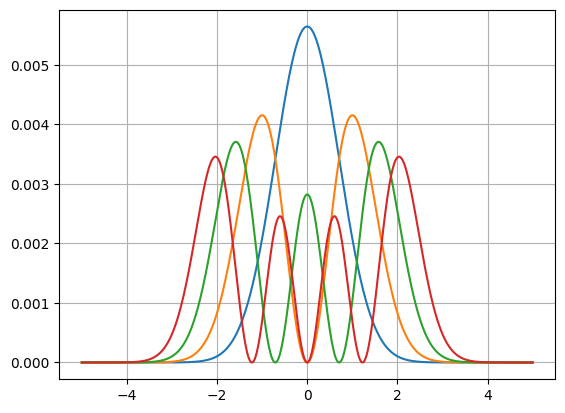

In [70]:
import matplotlib.pyplot as plt
for i in range(len(wfcs_com)):
  plt.plot(par.x, abs(wfcs_com[i])**2)

plt.grid()

In [ ]:
class COM_mode:
  """
  Container for holding operators and wavefunction coefficients for the COM mode.
  """
  def __init__(self, 
               res: int,
               omega: float = 1.0,
               num_wfcs: int = 1,
               T: float = 10e-6,
               r_t: list[float] = None,
               par: Param = None) -> None:

    # Initialize empty complex arrays for potential, propagators, and wavefunction
    self.V = np.empty(res, dtype=complex)  # Potential operator
    self.R = np.empty(res, dtype=complex)  # Real-space propagator
    self.K = np.empty(res, dtype=complex)  # Momentum-space propagator
    self.wfcs = np.empty((num_wfcs+1, res), dtype=complex)  # Wavefunction coefficients
    self.shifted_wfcs = np.empty((num_wfcs+1, res), dtype=complex)  # Shifted wavefunction coefficients
    
    # Store finite temperature
    self.T = T
    
    # Energy list for  (finite temperature case)
    self.energies = []
    self.probabilities = []
    
    # Density matrices
    self.rho = []
    self.shifted_rho = []
    
    # Average position
    self.avg_pos = []
    self.sigma_x = []
    self.total_drive = []
    
    # Infidelity
    self.average_infidelity = 0
    
    # Store time-dependent drive (default to no potential if None)
    self.r_t = r_t if r_t is not None else np.zeros(par.num_t)
    
    # Store angular frequency
    self.omega = omega
    
    # Store maximum order of the Hermite polynomial
    self.num_wfcs = num_wfcs

    # Initialize potential and wavefunction if a Param instance is provided
    if par is not None:
      self._initialize_operators(par)


  def reinitialize_operators(self, par: Param, pulse) -> None:
    """Reinitialize the operators with a new Param object."""
    # Reinitialize potential, propagators, and wavefunctions
    self.V = np.empty(self.V.shape, dtype=complex)
    self.R = np.empty(self.R.shape, dtype=complex)
    self.K = np.empty(self.K.shape, dtype=complex)
    self.wfcs = np.empty((self.num_wfcs, self.V.shape[0]), dtype=complex)
    self.shifted_wfcs = np.zeros((self.num_wfcs, self.V.shape[0]))

    # Reset density matrices and energy lists
    self.energies = []
    self.probabilities = []
    self.rho = []
    self.shifted_rho = []

    # Store new time-dependent drive
    self.r_t = pulse

    # Call the initialization function with the new parameter object
    self._initialize_operators(par)

  def _initialize_operators(self, par: Param) -> None:
    # Initial and final time-dependent offset
    r0 = self.r_t[0]
    rf = self.r_t[-1]

    # Quadratic potential with offset
    self.V = 0.5 * (par.x - r0) ** 2 * self.omega **2

    # Wavefunctions and shifted wavefunctions based on analytical solution for the harmonic oscillator
    self.wfcs = COM_spectrum(par.x - r0, self.omega, 8, self.num_wfcs)
    self.shifted_wfcs = COM_spectrum(par.x - rf, self.omega, 8, self.num_wfcs)
    
    # Coefficient for imaginary or real time evolution
    coeff = 1 if par.im_time else 1j

    # Momentum and real-space propagators
    self.K = np.exp(-0.5 * (par.k ** 2) * par.dt * coeff)
    self.R = np.exp(-0.5 * self.V * par.dt * coeff)
    
    # Energies and probabilities for mixed state density matrix
    self.energies = calculate_energies(self.wfcs, self.V, par)
    self.probabilities = calculate_probabilities(self.energies, self.T)
    
    # Density matrix
    self.rho = density_matrix(self.probabilities, self.wfcs, par.x, self.num_wfcs, self.omega, r0)
    self.shifted_rho = density_matrix(self.probabilities, self.shifted_wfcs, par.x, self.num_wfcs, self.omega, rf)


  def get_wavefunction(self, n):
    """Retrieve the nth wavefunction."""
    if n >= self.num_wfcs:
      raise ValueError(f"Requested wavefunction n={n} exceeds num_wfcs={self.num_wfcs}. Indexing starts from 0.")
    return self.wfcs[n]

  def get_shifted_wavefunction(self, n):
    """Retrieve the nth wavefunction."""
    if n >= self.num_wfcs:
      raise ValueError(f"Requested wavefunction n={n} exceeds num_wfcs={self.num_wfcs}. Indexing starts from 0.")
    return self.shifted_wfcs[n]

      
  def infidelity(self):
    overlap = np.trace(sqrtm(sqrtm(self.rho) @ self.shifted_rho @ sqrtm(self.rho)))
    infidelity = 1 - abs(overlap) ** 2
    #infidelity = np.maximum(0, infidelity)
    infidelity = np.clip(infidelity, 1e-3, 1)
    return infidelity
  
  
  def split_op(self, par: Param, fixed_potential: bool = False, compute_statistics: bool = False):
    # Set coefficient for real or imaginary time evolution
    coeff = 1 if par.im_time else 1j
    
    timesteps = par.num_t if not fixed_potential else par.num_tc
    par.total_time += timesteps * par.dt
    drive = self.r_t if not fixed_potential else np.full(par.num_tc, self.r_t[-1])
    self.total_drive.extend(drive)

    infidelities = []
    
    # Loop over the number of timesteps    
    for i in range(timesteps):
      # If not fixed, update the time-dependent potential
      self.V = 0.5 * (par.x - drive[i]) ** 2 * self.omega ** 2

      # Update the real-space propagator
      self.R = np.exp(-0.5 * self.V * par.dt * coeff)

      # Loop over all wavefunctions
      for n in range(self.num_wfcs):
        # Half-step in real space
        self.wfcs[n] *= self.R

        # Full step in momentum space
        self.wfcs[n] = np.fft.fft(self.wfcs[n])
        self.wfcs[n] *= self.K
        self.wfcs[n] = np.fft.ifft(self.wfcs[n])

        # Final half-step in real space
        self.wfcs[n] *= self.R
      
      self.energies = calculate_energies(self.wfcs, self.V, par)
      self.probabilities = calculate_probabilities(self.energies, self.T)
      self.rho = density_matrix(self.probabilities, self.wfcs, par.x, self.num_wfcs, self.omega, drive[i])
      
      if compute_statistics:  
        positions, sigma = position_statistics(par.x, self.wfcs)
        self.avg_pos.append(positions)
        self.sigma_x.append(sigma)
      
      if fixed_potential:
        infidelities.append(self.infidelity())
    

    self.average_infidelity = np.mean(infidelities) if fixed_potential else 0

  def time_evolution(self, par: Param, fixed_potential: bool = False, compute_statistics: bool = False):
    # Apply split operator to wfcs
    self.split_op(par, fixed_potential, compute_statistics)
    rf = self.r_t[-1] 
    self.shifted_rho = density_matrix(self.probabilities, self.shifted_wfcs, par.x, self.num_wfcs, self.omega, rf)

In [72]:
from qho_time_evolution import Param

xmin = -10.0
xmax = 10.0
num_x = 2000
tsim = 10
tc = 10
desired_dt = 0.1
num_t = int(tsim/desired_dt)
num_tc = int(tc/desired_dt)
im_time = False

# Initialize the Param object
par = Param(xmin, xmax, num_x, tsim, num_t, tc, num_tc, im_time)

In [ ]:
res = num_x
omega = 1.0
num_wfcs = 8
T = 1 
linear_pulse = lambda t: t/5
times = np.linspace(0, tsim, num_t)
pulse = linear_pulse(times)

# Initialize the Operators object
opr = COM_mode(res, omega, num_wfcs, T, pulse, par)

In [74]:
opr.rho

array([[6.323e-01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00],
       [0.000e+00, 2.326e-01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 8.560e-02, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 3.150e-02, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.160e-02, 0.000e+00,
        0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.300e-03,
        0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.600e-03, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 6.000e-04]])

In [75]:
print("Energies\n", opr.energies)

Energies
 [0.5000000000000004, 1.4999999999999978, 2.5000000000000018, 3.499999999999991, 4.5000000000000036, 5.499999999999995, 6.499999999999998, 7.500000000000016]


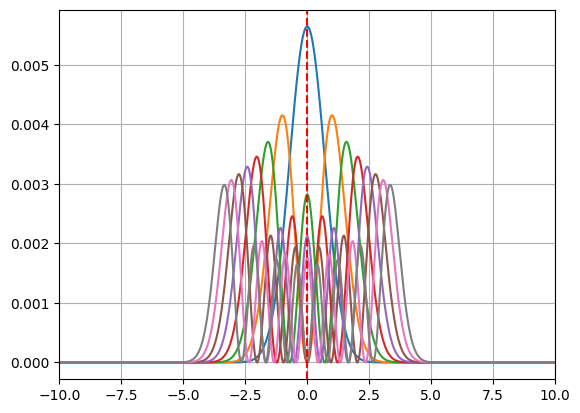

In [76]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)
  
plt.axvline(opr.r_t[0], color='red', linestyle='--')
plt.xlim(opr.r_t[0] - 10, opr.r_t[0] + 10)
plt.grid()
plt.show()

In [77]:
opr.infidelity()

0.001

In [78]:
opr.time_evolution(par, fixed_potential=False, compute_statistics=True)

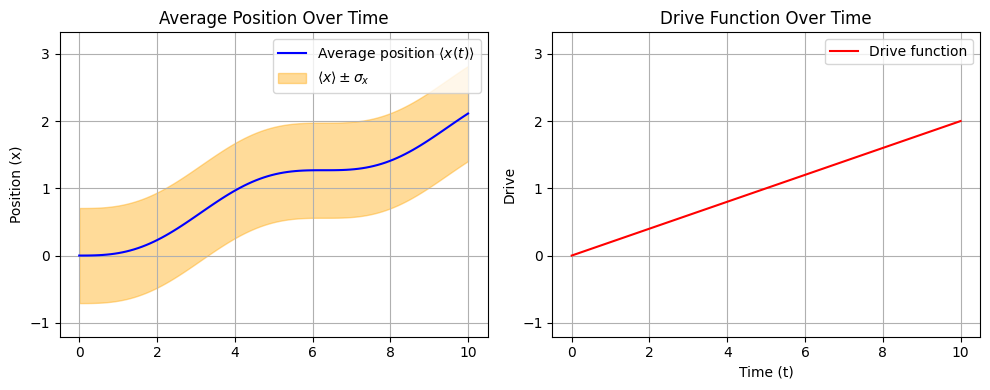

In [79]:
import plot
plot.plot_position_statistics(par, opr, 0)

In [80]:
print("Energies\n", opr.energies)

Energies
 [0.5768481748494904, 1.5768491139916654, 2.5768500531345415, 3.576850992276738, 4.576851931418752, 5.576852870561307, 6.576853809703942, 7.576854748846101]


In [82]:
def plot_wavefunctions(opr, shifted=False):
  wfcs = opr.wfcs if not shifted else opr.shifted_wfcs
  for i in range(opr.num_wfcs):
    plt.plot(par.x, abs(wfcs[i])**2)
  
  plt.axvline(opr.r_t[0], color='blue', linestyle='--', label="Starting point")
  plt.axvline(opr.r_t[-1], color='red', linestyle='--', label="Ending point")
  plt.xlim(opr.r_t[-1] - 7, opr.r_t[-1] + 7)
  
  plt.grid()
  plt.legend()
  plt.show()

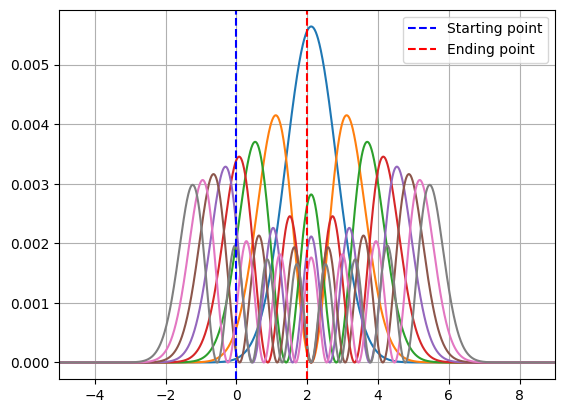

In [83]:
plot_wavefunctions(opr)

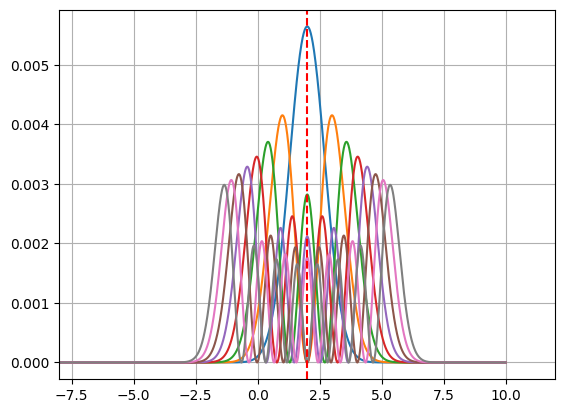

In [84]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.shifted_wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.xlim(opr.r_t[-1] - 10, opr.r_t[-1] + 10)
plt.grid()
plt.show()

In [85]:
opr.infidelity()

0.034663873637026544085

In [86]:
opr.time_evolution(par, fixed_potential=True, compute_statistics=True)

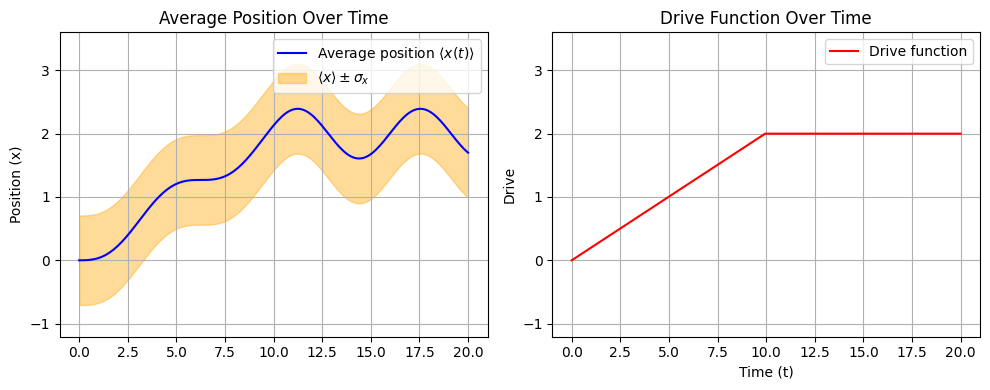

In [87]:
plot.plot_position_statistics(par, opr, 0)

In [93]:
opr.rho

array([[ 6.026e-01+0.000e+00j, -3.010e-02-1.013e-01j,
        -1.060e-02+7.300e-03j,  1.000e-03+7.000e-04j,
         0.000e+00-1.000e-04j,  0.000e+00-0.000e+00j,
        -0.000e+00-0.000e+00j,  0.000e+00-0.000e+00j],
       [-3.010e-02+1.013e-01j,  2.402e-01+0.000e+00j,
        -1.640e-02-5.480e-02j, -6.900e-03+4.800e-03j,
         8.000e-04+6.000e-04j,  0.000e+00-1.000e-04j,
         0.000e+00+0.000e+00j, -0.000e+00-0.000e+00j],
       [-1.060e-02-7.300e-03j, -1.640e-02+5.480e-02j,
         9.540e-02+0.000e+00j, -7.700e-03-2.570e-02j,
        -3.700e-03+2.600e-03j,  5.000e-04+3.000e-04j,
         0.000e+00-1.000e-04j, -0.000e+00-0.000e+00j],
       [ 1.000e-03-7.000e-04j, -6.900e-03-4.800e-03j,
        -7.700e-03+2.570e-02j,  3.780e-02+0.000e+00j,
        -3.400e-03-1.140e-02j, -1.800e-03+1.300e-03j,
         2.000e-04+2.000e-04j,  0.000e+00-0.000e+00j],
       [ 0.000e+00+1.000e-04j,  8.000e-04-6.000e-04j,
        -3.700e-03-2.600e-03j, -3.400e-03+1.140e-02j,
         1.500e-02+0.000

In [89]:
print("Energies\n", opr.energies)

Energies
 [0.5769456283824955, 1.5769482588289991, 2.576950889276233, 3.576953519722744, 4.576956150169093, 5.5769587806161, 6.576961411065049, 7.576964041542058]


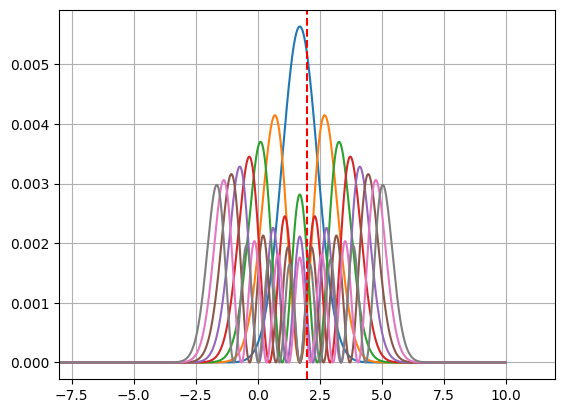

In [90]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.xlim(opr.r_t[-1] - 10, opr.r_t[-1] + 10)
plt.grid()
plt.show()

In [91]:
opr.infidelity()

0.034712840996958130486

In [92]:
opr.average_infidelity

0.03470466064339039114

In [6]:
def STR_potential(x_str, omega_str, e2=1):
  """
  Computes the potential for the stretch mode, including harmonic and Coulomb terms.
  
  Parameters
  ----------
  x_str : np.ndarray
      Stretch coordinate grid.
  omega_str : float
      Frequency of the stretch mode.
  e2 : float, optional
      Coulomb interaction strength (default is 1 in atomic units).

  Returns
  -------
  V_str : np.ndarray
      Diagonal of the potential matrix.
  """
  mu = 0.5  # Reduced mass in natural units
  V_harmonic = 0.5 * mu * omega_str**2 * x_str**2
  V_coulomb = e2 / np.abs(x_str)
  V_coulomb[np.isinf(V_coulomb)] = 1e6  # Regularization to avoid division by zero
  
  return V_harmonic + V_coulomb

def STR_hamiltonian(x_str, omega_str, order=8):
  """
  Constructs the Hamiltonian for the stretch mode.

  Parameters
  ----------
  x_str : np.ndarray
    Stretch coordinate grid.
  omega_str : float
    Frequency of the stretch mode.
  order : int, optional
    Order of finite difference approximation. Default is 8.

  Returns
  -------
  H_str : scipy.sparse.csr_matrix
    Stretch mode Hamiltonian.
  """
  # Construct Kinetic Energy Matrix (Reduced Mass)
  mu = 0.5  # Reduced mass in natural units
  K_str = kinetic_matrix(x_str, order) / (2 * mu)  # Scaling the kinetic term
  
  # Construct Potential Energy Matrix
  V_diag = STR_potential(x_str, omega_str)
  V_str = np.diag(V_diag)

  # Total Hamiltonian
  H_str = K_str + V_str
  return H_str

def STR_spectrum(x_str, omega_str, order=8, n_max=1):
  """
  Computes the eigenfunctions of the stretch mode Hamiltonian.

  Parameters
  ----------
  x_str : np.ndarray
    Stretch coordinate grid.
  omega_str : float
    Frequency of the stretch mode.
  order : int, optional
    Order of finite difference approximation. Default is 8.
  n_max : int, optional
    Number of wavefunctions to return. Default is 1.

  Returns
  -------
  np.ndarray
    Normalized wavefunctions.
  """
  H_str = STR_hamiltonian(x_str, omega_str, order)
  energies, psi_str = eigh(H_str)
  
  # Normalize
  psi_str = psi_str.T / np.sqrt(np.sum(np.abs(psi_str.T)**2, axis=0))
  return psi_str[:n_max].astype(complex), energies[:n_max]


In [7]:

# ===========================================================================================================
# AUXILIARY FUNCTIONS FOR OPERATOR CLASS
# ===========================================================================================================

def energy_basis(psi, x, num_wfcs, omega, delta_x):
  """
  Project the wavefunction `psi` onto the energy eigenbasis (Hermite functions).
  """
  # Initialize coefficients in energy basis
  coeff = np.zeros((num_wfcs, num_wfcs), dtype=complex)
  true_psi, _ = STR_spectrum(x - delta_x, omega, 8, num_wfcs)
  
  # Loop over energy levels and compute overlap
  for n in range(num_wfcs):
    for i in range(num_wfcs):
      coeff[i, n] = true_psi[i] @ np.conj(psi[n])
  return np.round(np.real_if_close(coeff), 4)

def density_matrix(probabilities, wavefunctions, x, num_wfcs, omega, delta_x):
  rho = 0
  rho = np.zeros((num_wfcs, num_wfcs), dtype=complex)
  coefficients = energy_basis(wavefunctions, x, num_wfcs, omega, delta_x)
  
  for i in range(num_wfcs):
    rho += probabilities[i] * np.outer(coefficients[i], np.conj(coefficients[i]))
    
  rho /= np.trace(rho)
  rho = np.nan_to_num(rho, nan=0.0)

  return np.round(np.real_if_close(rho), 4)

def calculate_energies(wavefunctions, potential, par: Param):
  energies = []
  
  for wfc in wavefunctions:
    # Creating momentum and conjugate wavefunctions.
    wfc_k = np.fft.fft(wfc)
    wfc_c = np.conj(wfc)
    
    # Finding the momentum and real-space energy terms
    energy_k = 0.5 * wfc_c * np.fft.ifft((par.k ** 2) * wfc_k)
    energy_r = wfc_c * potential * wfc
    
    # Integrating over all space
    energy_final = sum(energy_k + energy_r).real
    
    # Store the energy
    energies.append(energy_final)
  
  return energies

def calculate_probabilities(energies, T):
  # Store probabilities for mixed state density matrix
  probs = [np.exp(-energies[i] / T) for i in range(len(energies))]
  probs /= np.sum(probs)
    
  return probs

def position_statistics(x, wavefunctions):
  avg_positions = []
  avg_positions_squared = []

  for wfc in wavefunctions:
    density = np.abs(wfc) ** 2
    avg_x = np.sum(x * density)
    avg_x2 = np.sum((x ** 2) * density)

    avg_positions.append(avg_x)
    avg_positions_squared.append(avg_x2)

  avg_positions = np.array(avg_positions)
  avg_positions_squared = np.array(avg_positions_squared)

  # Compute standard deviation: σ_x = sqrt(⟨x²⟩ - ⟨x⟩²)
  sigma_x = np.sqrt(avg_positions_squared - avg_positions ** 2)

  return avg_positions, sigma_x

#def HamiltonianCOM()


# ===========================================================================================================
# OPERATORS CLASS
# ===========================================================================================================




In [32]:
class STR_mode:
  """
  Container for holding operators and wavefunction coefficients for the STR mode.
  """
  def __init__(self, 
               res: int,
               omega: float = 1.0,
               num_wfcs: int = 1,
               T: float = 10e-6,
               r_t: list[float] = None,
               par: Param = None) -> None:

    # Initialize empty complex arrays for potential, propagators, and wavefunction
    self.wfcs = np.empty((num_wfcs, res), dtype=complex)  # Wavefunction coefficients
    self.shifted_wfcs = np.empty((num_wfcs, res), dtype=complex)  # Shifted wavefunction coefficients
    
    # Store finite temperature
    self.T = T
    
    # Energy list for  (finite temperature case)
    self.energies = []
    self.shited_energies = []
    self.probabilities = []
    self.shifted_probabilities = []
    
    # Density matrices
    self.rho = []
    self.shifted_rho = []
    
    # Average position
    self.avg_pos = []
    self.sigma_x = []
    self.total_drive = []
    
    # Infidelity
    self.average_infidelity = 0
    
    # Store time-dependent drive (default to no potential if None)
    self.r_t = r_t if r_t is not None else np.zeros(par.num_t)
    
    # Store angular frequency
    self.omega = omega
    
    # Store maximum order of the Hermite polynomial
    self.num_wfcs = num_wfcs

    # Initialize potential and wavefunction if a Param instance is provided
    if par is not None:
      self._initialize_operators(par)


  def reinitialize_operators(self, par: Param, pulse) -> None:
    """Reinitialize the operators with a new Param object."""
    # Reinitialize potential, propagators, and wavefunctions
    self.wfcs = np.empty((self.num_wfcs, self.V.shape[0]), dtype=complex)
    self.shifted_wfcs = np.zeros((self.num_wfcs, self.V.shape[0]))

    # Reset density matrices and energy lists
    self.energies = []
    self.probabilities = []
    self.rho = []
    self.shifted_rho = []

    # Store new time-dependent drive
    self.r_t = pulse

    # Call the initialization function with the new parameter object
    self._initialize_operators(par)

  def _initialize_operators(self, par: Param) -> None:
    # Initial and final time-dependent offset
    r0 = self.r_t[0]
    rf = self.r_t[-1]

    # Wavefunctions and shifted wavefunctions based on analytical solution for the harmonic oscillator
    self.wfcs, self.energies = STR_spectrum(par.x, self.omega, 8, self.num_wfcs)
    self.shifted_wfcs, self.shifted_energies = STR_spectrum(par.x, self.omega, 8, self.num_wfcs)
    
    self.probabilities = calculate_probabilities(self.energies, self.T)
    self.shifted_probabilities = calculate_probabilities(self.shifted_energies, self.T)
    
    # Density matrix
    self.rho = density_matrix(self.probabilities, self.wfcs, par.x, self.num_wfcs, self.omega, r0)
    self.shifted_rho = density_matrix(self.shifted_probabilities, self.shifted_wfcs, par.x, self.num_wfcs, self.omega, rf)


  def get_wavefunction(self, n):
    """Retrieve the nth wavefunction."""
    if n >= self.num_wfcs:
      raise ValueError(f"Requested wavefunction n={n} exceeds num_wfcs={self.num_wfcs}. Indexing starts from 0.")
    return self.wfcs[n]

  def get_shifted_wavefunction(self, n):
    """Retrieve the nth wavefunction."""
    if n >= self.num_wfcs:
      raise ValueError(f"Requested wavefunction n={n} exceeds num_wfcs={self.num_wfcs}. Indexing starts from 0.")
    return self.shifted_wfcs[n]

      
  def infidelity(self):
    overlap = np.trace(sqrtm(sqrtm(self.rho) @ self.shifted_rho @ sqrtm(self.rho)))
    infidelity = 1 - abs(overlap) ** 2
    #infidelity = np.maximum(0, infidelity)
    infidelity = np.clip(infidelity, 1e-3, 1)
    return infidelity
  
  def evolve_stretch_mode(self, par: Param, fixed_potential: bool = False, compute_statistics: bool = False):
    """Evolves the stretch mode using exact diagonalization."""
    timesteps = par.num_t if not fixed_potential else par.num_tc
    infidelities = []

    # Time evolution
    for t in range(timesteps):
      phase = np.exp(-1j * self.energies * par.dt * t)
      wf_t = self.wfcs * phase[:, np.newaxis] 
      self.wfcs = wf_t  # Store evolved wavefunction
      
      self.probabilities = calculate_probabilities(self.energies, self.T)
      self.rho = density_matrix(self.probabilities, self.wfcs, par.x, self.num_wfcs, self.omega, 0)
      
      if compute_statistics:  
        positions, sigma = position_statistics(par.x, self.wfcs)
        self.avg_pos.append(positions)
        self.sigma_x.append(sigma)
      
      if fixed_potential:
        infidelities.append(self.infidelity())
    
    self.average_infidelity = np.mean(infidelities) if fixed_potential else 0


  def time_evolution(self, par: Param, fixed_potential: bool = False, compute_statistics: bool = False):
    # Apply split operator to wfcs
    self.evolve_stretch_mode(par, fixed_potential, compute_statistics)
    self.shifted_rho = density_matrix(self.probabilities, self.shifted_wfcs, par.x, self.num_wfcs, self.omega, 0)

In [33]:
from qho_time_evolution import Param

xmin = -10.0
xmax = 10.0
num_x = 2000
tsim = 10
tc = 10
desired_dt = 0.1
num_t = int(tsim/desired_dt)
num_tc = int(tc/desired_dt)
im_time = False

# Initialize the Param object
par = Param(xmin, xmax, num_x, tsim, num_t, tc, num_tc, im_time)

In [34]:
wfcs_str, energies = STR_spectrum(par.x, 1, 8, 5)

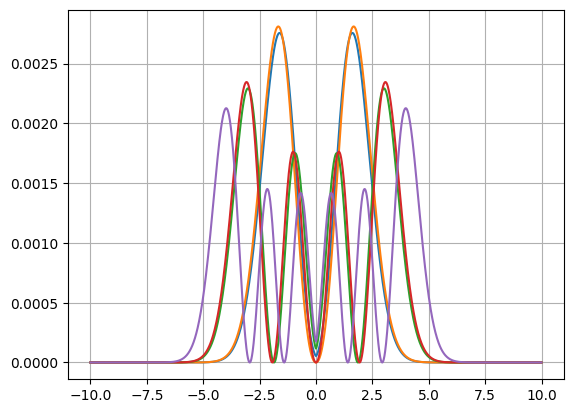

In [35]:
import matplotlib.pyplot as plt
for i in range(len(wfcs_str)):
  plt.plot(par.x, abs(wfcs_str[i])**2)

plt.grid()

In [36]:
res = num_x
omega = 1.0
num_wfcs = 8
T = 1 
linear_pulse = lambda t: t/5
times = np.linspace(0, tsim, num_t)
pulse = linear_pulse(times)

# Initialize the Operators object
opr = STR_mode(res, omega, num_wfcs, T, pulse, par)

In [37]:
opr.rho

array([[0.4353, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.4126, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.0687, 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.0614, 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.0104, 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.0088, 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0015, 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0012]])

In [38]:
print("Energies\n", opr.energies)

Energies
 [2.17656414 2.23012206 4.02296313 4.13447628 5.90844477 6.07396684
 7.81633665 8.03095638]


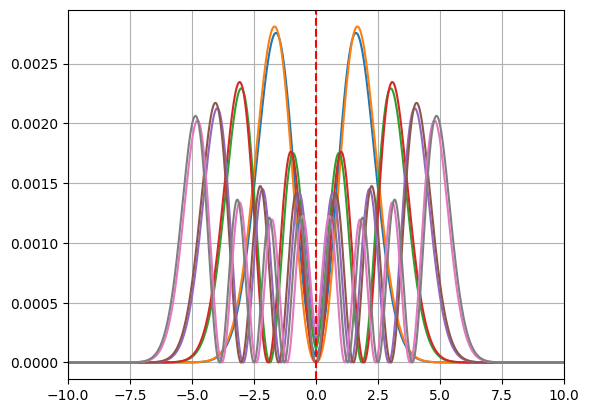

In [39]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)
  
plt.axvline(opr.r_t[0], color='red', linestyle='--')
plt.xlim(opr.r_t[0] - 10, opr.r_t[0] + 10)
plt.grid()
plt.show()

In [40]:
opr.infidelity()

0.5351634457461334

In [41]:
opr.time_evolution(par, fixed_potential=False, compute_statistics=True)

In [43]:
opr.avg_pos

[array([ 1.03202114e-10, -1.05594866e-10,  7.30970839e-13, -1.69309011e-12,
        -7.09126091e-11,  7.34978745e-11, -7.86011256e-11,  7.93003441e-11]),
 array([ 1.03202114e-10, -1.05594866e-10,  7.31192884e-13, -1.69309011e-12,
        -7.09123871e-11,  7.34978745e-11, -7.86011256e-11,  7.93003441e-11]),
 array([ 1.03202114e-10, -1.05595088e-10,  7.31192884e-13, -1.69331216e-12,
        -7.09119430e-11,  7.34983185e-11, -7.86015697e-11,  7.93001220e-11]),
 array([ 1.03202002e-10, -1.05594866e-10,  7.31192884e-13, -1.69331216e-12,
        -7.09123871e-11,  7.34983185e-11, -7.86011256e-11,  7.93005661e-11]),
 array([ 1.03202114e-10, -1.05594866e-10,  7.31192884e-13, -1.69331216e-12,
        -7.09121650e-11,  7.34983185e-11, -7.86013477e-11,  7.93001220e-11]),
 array([ 1.03202114e-10, -1.05595088e-10,  7.30970839e-13, -1.69331216e-12,
        -7.09121650e-11,  7.34980965e-11, -7.86013477e-11,  7.93003441e-11]),
 array([ 1.03202114e-10, -1.05595088e-10,  7.30970839e-13, -1.69309011e-12,


ValueError: x and y must have same first dimension, but have shapes (0,) and (100,)

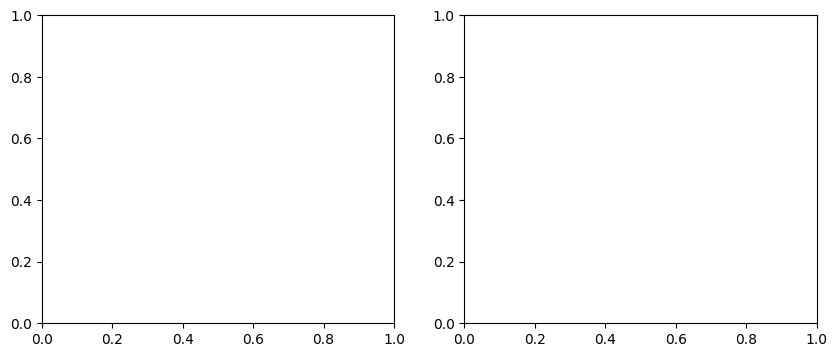

In [42]:
import plot
plot.plot_position_statistics(par, opr, 0)

In [44]:
print("Energies\n", opr.energies)

Energies
 [2.17656414 2.23012206 4.02296313 4.13447628 5.90844477 6.07396684
 7.81633665 8.03095638]


In [45]:
def plot_wavefunctions(opr, shifted=False):
  wfcs = opr.wfcs if not shifted else opr.shifted_wfcs
  for i in range(opr.num_wfcs):
    plt.plot(par.x, abs(wfcs[i])**2)
  
  plt.axvline(opr.r_t[0], color='blue', linestyle='--', label="Starting point")
  plt.axvline(opr.r_t[-1], color='red', linestyle='--', label="Ending point")
  plt.xlim(opr.r_t[-1] - 7, opr.r_t[-1] + 7)
  
  plt.grid()
  plt.legend()
  plt.show()

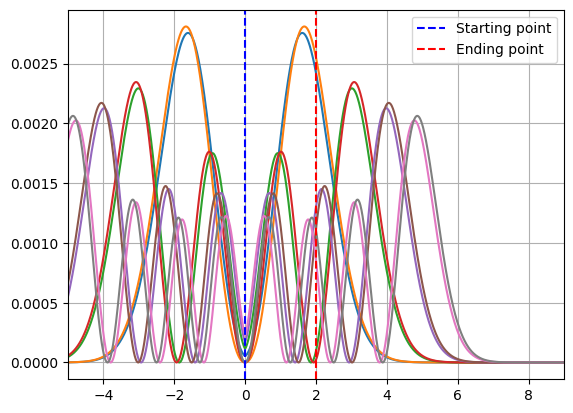

In [46]:
plot_wavefunctions(opr)

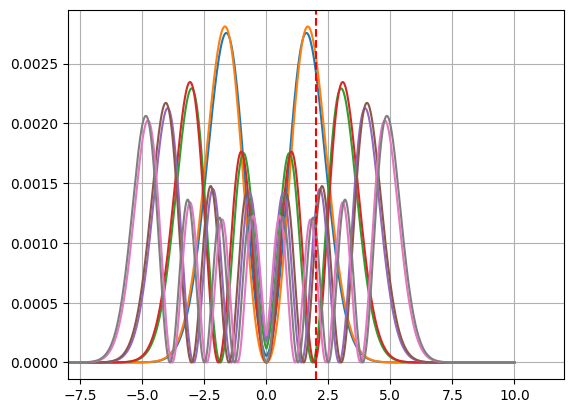

In [47]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.shifted_wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.xlim(opr.r_t[-1] - 10, opr.r_t[-1] + 10)
plt.grid()
plt.show()

In [48]:
opr.infidelity()

0.001

In [49]:
opr.time_evolution(par, fixed_potential=True, compute_statistics=True)

ValueError: x and y must have same first dimension, but have shapes (0,) and (200,)

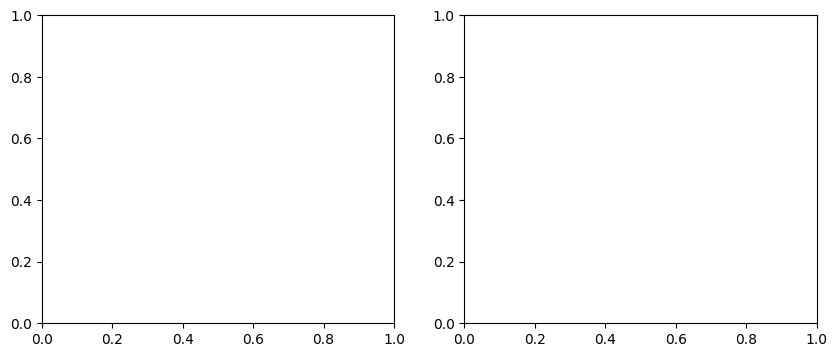

In [50]:
plot.plot_position_statistics(par, opr, 0)

In [51]:
opr.rho

array([[0.4353, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.4126, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.0687, 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.0614, 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.0104, 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.0088, 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0015, 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0012]])

In [52]:
print("Energies\n", opr.energies)

Energies
 [2.17656414 2.23012206 4.02296313 4.13447628 5.90844477 6.07396684
 7.81633665 8.03095638]


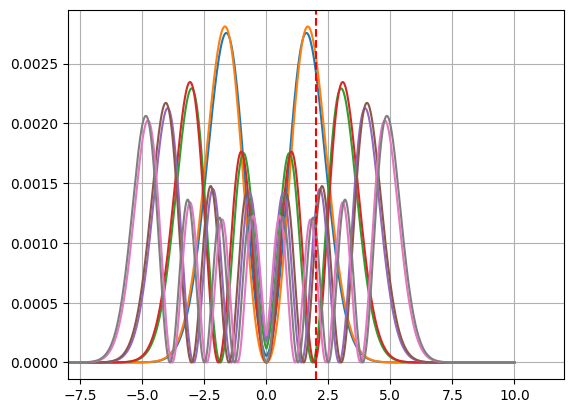

In [53]:
for i in range(opr.num_wfcs):
  plt.plot(par.x, abs(opr.wfcs[i])**2)

plt.axvline(opr.r_t[-1], color='red', linestyle='--')
plt.xlim(opr.r_t[-1] - 10, opr.r_t[-1] + 10)
plt.grid()
plt.show()

In [54]:
opr.infidelity()

0.001

In [55]:
opr.average_infidelity

0.0010000000000000002